# Climate Analysis

Assume my vacation will be christmas of 2016, from 2016-12-24 to 2017-01-01.

**TODO** FInd out where join station and measurement is needed

In [26]:
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
from sqlalchemy import create_engine, select, func, desc, and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

sns.set_style('darkgrid')
_SQLITE_FILE = 'hawaii.sqlite'

engine = create_engine(f'sqlite:///{_SQLITE_FILE}')

Base = automap_base()
Base.prepare(engine, reflect=True)

Measurement = Base.classes.measurement
Station = Base.classes.station

VACATION_START_DATE = date(2017, 12, 24)
VACATION_END_DATE = date(2018,1, 1)
VACATION_START_DATE_PREV_YEAR =  VACATION_START_DATE - relativedelta(years=1)
VACATION_END_DATE_PREV_YEAR = VACATION_END_DATE - relativedelta(years=1)
 
session = Session(engine)

MAX_DATE = session.query(func.max(Measurement.date)).all()[0][0]
MAX_DATE_MINUS_12_MONTH = MAX_DATE - relativedelta(months=12)

## Step 1 - Precipitation Analysis

In [27]:
df_prcp_summary = pd.read_sql(
    select([Measurement.date, Measurement.prcp]).where(
        Measurement.date.between(MAX_DATE_MINUS_12_MONTH, MAX_DATE)
    ),
    engine).groupby('date').mean()

In [28]:
df_prcp_summary.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


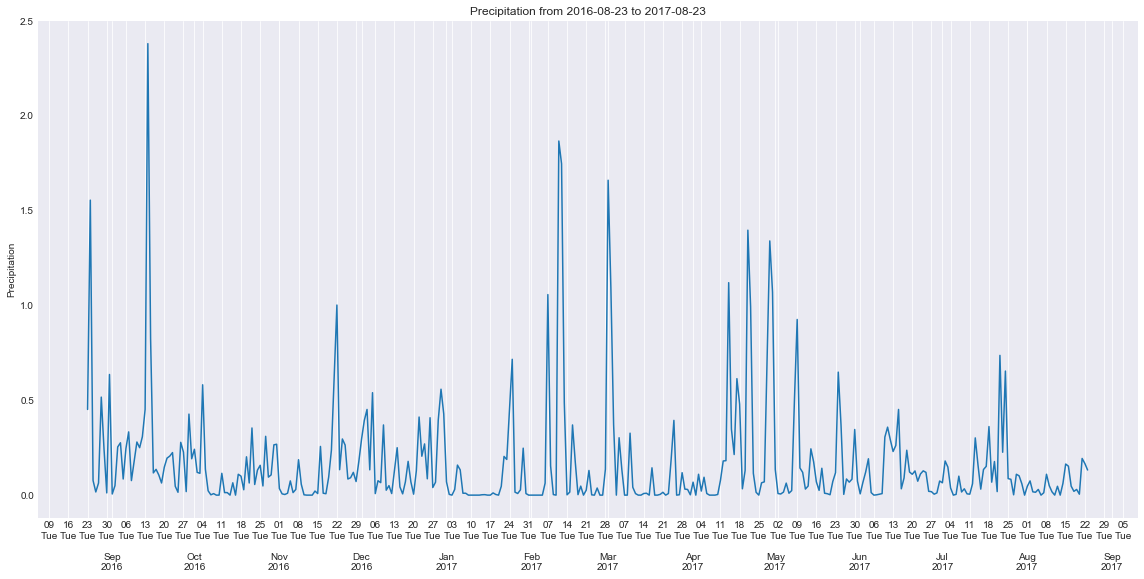

In [29]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot_date(df_prcp_summary.index,
             df_prcp_summary['prcp'], '-',
             label='precipitation')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.ylabel('Precipitation')
plt.tight_layout()
plt.title(f'Precipitation from {MAX_DATE_MINUS_12_MONTH} to {MAX_DATE}')
plt.show()

## Step 2 - Station Analysis

* Total Number of Stations

In [30]:
pd.read_sql(select([func.count(Station.id)]), engine)

,count_1
0,9


In [31]:
session.query(func.count(Station.id)).all()

[(9)]

In [32]:
[r for r in engine.execute('select count(*) from station')]

[(9,)]

* Most Active Stations

In [33]:
cnt = func.count(Measurement.id)
stn = Measurement.station
df_top_station = pd.read_sql(select([stn, cnt]).group_by(stn).order_by(desc(cnt)), engine)
df_top_station.head()

,station,count_1
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484


Station USC00519281	 has the highest number of observations.

In [34]:
top_station = df_top_station.at[0, 'station']

* Last 12 month of observation data (tobs)

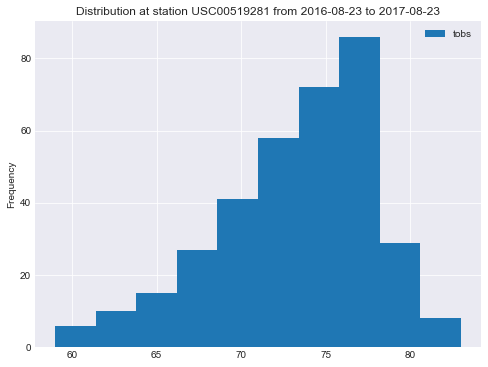

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.read_sql(
    select([Measurement.tobs]).where(
        and_(
            Measurement.station == top_station, 
            Measurement.date.between(MAX_DATE_MINUS_12_MONTH, MAX_DATE)
        )
    ),
    engine
).plot.hist(ax=ax)
plt.title(f"Distribution at station {top_station} from {MAX_DATE_MINUS_12_MONTH} to {MAX_DATE}")
plt.show()

## Step3 -Temperature Analysis

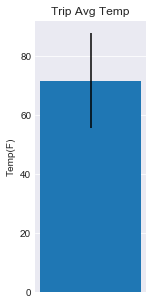

In [36]:
def calc_temps(start_date, end_date):
    temp = Measurement.tobs
    result = session.query(func.min(temp), func.avg(temp), func.max(temp)).filter(
            Measurement.date.between(start_date, end_date)
    )
    return result.all()[0]

(min_temp, avg_temp, max_temp) = calc_temps(VACATION_START_DATE_PREV_YEAR, VACATION_END_DATE_PREV_YEAR)

fig, ax = plt.subplots(figsize=(2,5))
ax.bar([0], [avg_temp], width=1, yerr=max_temp - min_temp)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
ax.xaxis.set_visible(False)
plt.show()

## Optional Recommended Analysis

### Average Rainfall per station 

In [37]:
session.query(
    Measurement.station, 
    func.avg(Measurement.prcp)
).filter(
    Measurement.date.between(VACATION_START_DATE_PREV_YEAR, VACATION_END_DATE_PREV_YEAR)
).group_by(
    Measurement.station
).all()

[('USC00513117', 0.20555555555555557),
 ('USC00514830', 0.19571428571428573),
 ('USC00516128', 0.838888888888889),
 ('USC00519281', 0.18555555555555558),
 ('USC00519397', 0.024444444444444446),
 ('USC00519523', 0.04285714285714286)]

### Daily Normals

In [38]:
def daily_normals(date):
    prcp = Measurement.prcp
    return session.query(func.min(prcp), func.avg(prcp), func.max(prcp)).filter_by(
        date=date
    ).all()[0]

df_normals = pd.DataFrame(
    [
        [date, *daily_normals(date)]
        for date in pd.date_range(VACATION_START_DATE_PREV_YEAR, VACATION_END_DATE_PREV_YEAR)
    ],
    columns = ['date', 'tmin', 'tavg', 'tmax']
)    

In [39]:
df_normals

,date,tmin,tavg,tmax
0,2016-12-24,0.01,0.270000,1.08
1,2016-12-25,0.00,0.086000,0.38
2,2016-12-26,0.02,0.408000,1.48
3,2016-12-27,0.00,0.040000,0.14
4,2016-12-28,0.01,0.068333,0.14
5,2016-12-29,0.04,0.396667,1.03
6,2016-12-30,0.07,0.558333,2.37
7,2016-12-31,0.01,0.428000,0.90
8,2017-01-01,0.00,0.070000,0.29


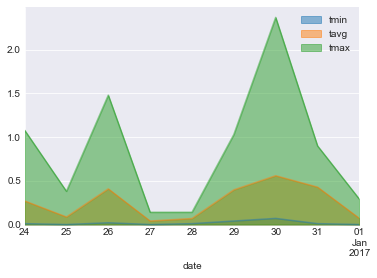

In [40]:
df_normals.set_index('date').plot.area(stacked=False)
plt.show()

In [55]:
session.close()

## Step 4 - Climate App

？？？ What's last year, what is prevoius year???

In [51]:
from flask import Flask, jsonify
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import pandas as pd
from sqlalchemy import create_engine, select, func, desc, and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

_SQLITE_FILE = 'hawaii.sqlite'
engine = create_engine(f'sqlite:///{_SQLITE_FILE}')
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

END_DATE = session.query(func.max(Measurement.date)).all()[0][0]
START_DATE = END_DATE - relativedelta(months=12)

app = Flask(__name__)

@app.route('/api/v1.0/precipitation')
def precipitation():
    return jsonify(
        session.query(
            Measurement.date, func.avg(Measurement.tobs)
        ).filter(
            Measurement.date.between(START_DATE, END_DATE)
        ).all()
    )

if __name__ == '__main__':
    app.run(debug=True, port=5555)

In [69]:
        a = Session(engine).query(
            Measurement.date, func.avg(Measurement.tobs)
        ).filter(
            Measurement.date.between(START_DATE, END_DATE)
        ).group_by(
            Measurement.date
        ).all()

In [70]:
a

[(datetime.date(2016, 8, 23), 78.0),
 (datetime.date(2016, 8, 24), 77.5),
 (datetime.date(2016, 8, 25), 79.42857142857143),
 (datetime.date(2016, 8, 26), 80.5),
 (datetime.date(2016, 8, 27), 77.4),
 (datetime.date(2016, 8, 28), 76.0),
 (datetime.date(2016, 8, 29), 78.5),
 (datetime.date(2016, 8, 30), 77.33333333333333),
 (datetime.date(2016, 8, 31), 77.8),
 (datetime.date(2016, 9, 1), 79.8),
 (datetime.date(2016, 9, 2), 78.8),
 (datetime.date(2016, 9, 3), 77.4),
 (datetime.date(2016, 9, 4), 77.0),
 (datetime.date(2016, 9, 5), 79.0),
 (datetime.date(2016, 9, 6), 75.6),
 (datetime.date(2016, 9, 7), 75.83333333333333),
 (datetime.date(2016, 9, 8), 78.5),
 (datetime.date(2016, 9, 9), 77.16666666666667),
 (datetime.date(2016, 9, 10), 76.8),
 (datetime.date(2016, 9, 11), 77.2),
 (datetime.date(2016, 9, 12), 76.0),
 (datetime.date(2016, 9, 13), 77.33333333333333),
 (datetime.date(2016, 9, 14), 75.83333333333333),
 (datetime.date(2016, 9, 15), 78.16666666666667),
 (datetime.date(2016, 9, 16), 

In [76]:
start = None
end = None

start = start or '1700-01-01'
end = end or '9999-12-31'
tobs = Measurement.tobs

Session(engine).query(
        func.min(tobs), func.avg(tobs), func.max(tobs)
       ).filter(
            Measurement.date.between(start, end)
        ).all()[0]

(53, 72.99486272993427, 87)

In [81]:
start = '2017-01-01'
end = '2017-10-01'
Session(engine).query(
            func.min(tobs), func.avg(tobs), func.max(tobs)
        ).filter(
            Measurement.date.between(start, end)
        ).all()[0]

(58, 74.02052091554854, 87)